# Notebook 4b: Ray tracing on the GPU

Here we compare the CPU and GPU implementations of ray tracing.

Please see notebook 4a for details.

In [5]:
import paicos as pa
import numpy as np
pa.use_units(True)

# Load snapshot
snap = pa.Snapshot(pa.data_dir, 247)

center = snap.Cat.Group['GroupPos'][0]
R200c = snap.Cat.Group['Group_R_Crit200'][0]
widths = np.array([10000, 10000, 10000]) * R200c.uq

# Pixels along horizontal direction
npix = 256

# Do some arbitrary orientation
orientation = pa.Orientation(normal_vector=[0, 0, 1], perp_vector1=[1, 0, 0])
orientation.rotate_around_normal_vector(degrees=20)
orientation.rotate_around_perp_vector1(degrees=35)
orientation.rotate_around_perp_vector2(degrees=-47)

# Initialize projectors
tree_projector = pa.TreeProjector(snap, center, widths, orientation, npix=npix,
                                  tol=0.25)

gpu_projector = pa.GpuRayProjector(snap, center, widths, orientation, npix=npix,
                                   threadsperblock=8, do_pre_selection=True,
                                   tol=0.25)

# Project density
tree_dens = tree_projector.project_variable('0_Density', additive=False)
gpu_dens = gpu_projector.project_variable('0_Density', additive=False)

Attempting to get derived variable: 0_Volume...	[DONE]



### Plot comparison between CPU and GPU

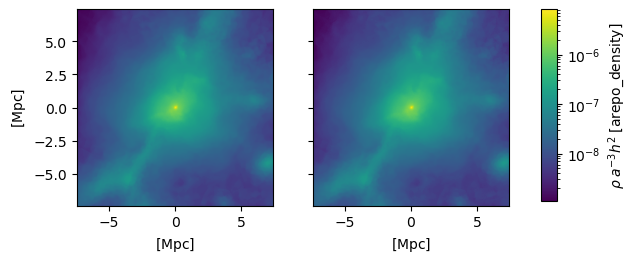

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(1)
plt.clf()
fig, axes = plt.subplots(num=1, ncols=2, sharex=True, sharey=True)

extent = tree_projector.centered_extent.to_physical.astro.to('Mpc')
axes[0].imshow(tree_dens.value, extent=extent.value, norm=LogNorm(tree_dens.value.min(), tree_dens.value.max()))
im = axes[1].imshow(gpu_dens.value, extent=extent.value, norm=LogNorm(tree_dens.value.min(), tree_dens.value.max()))

# Add a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.025, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)

# Set the labels. The units for the labels are here set using the .label method
# of the PaicosQuantity. This internally uses astropy functionality and is
# mainly a convenience function.
cbar.set_label(tree_dens.label('\\rho'))
axes[0].set_ylabel(extent.label())
axes[0].set_xlabel(extent.label())
axes[1].set_xlabel(extent.label())

plt.show()